# Life Expectancy Estimation

## Goal

The goal of this project is to first analyze the driving factors of life expectancy, and then use machine learning models in order to give an estimate of this feature for a given country.

## Data

The dataset used for this project is the [Life Expectancy Data](https://www.kaggle.com/datasets/lashagoch/life-expectancy-who-updated?select=Life-Expectancy-Data-Updated.csv) from Kaggle, collected by the World Health Organization. It contains 22 features for 193 countries, for a period between 2000 and 2015.  
We have downloaded the `.csv` file and put it in the `data` folder.

## Analysis

These are some important questions we need to discover:
- What are the variables affecting life expectancy?
- What is relationship between infant and adult mortality and life expectancy?
- Is there a positive or negative correlation between life expectancy and drinking habits?
- What is the impact of schooling on the lifespan of humans?
- Do densely populated countries tend to have a lower life expectancy?
- What is the relationship between life expectancy and Immunization coverage?

And much more...

## Import Libraries and Load Data

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.figsize'] = (5, 5)

In [2]:
# load data
df = pd.read_csv('../data/life_expectancy.csv')

In [3]:
# inspect data
df.head()

,Country,Region,Year,Infant_deaths,Under_five_deaths,Adult_mortality,Alcohol_consumption,Hepatitis_B,Measles,BMI,...,Diphtheria,Incidents_HIV,GDP_per_capita,Population_mln,Thinness_ten_nineteen_years,Thinness_five_nine_years,Schooling,Economy_status_Developed,Economy_status_Developing,Life_expectancy
0,Turkiye,Middle East,2015,11.1,13.0,105.8240,1.32,97,65,27.8,...,97,0.08,11006,78.53,4.9,4.8,7.8,0,1,76.5
1,Spain,European Union,2015,2.7,3.3,57.9025,10.35,97,94,26.0,...,97,0.09,25742,46.44,0.6,0.5,9.7,1,0,82.8
2,India,Asia,2007,51.5,67.9,201.0765,1.57,60,35,21.2,...,64,0.13,1076,1183.21,27.1,28.0,5.0,0,1,65.4
3,Guyana,South America,2006,32.8,40.5,222.1965,5.68,93,74,25.3,...,93,0.79,4146,0.75,5.7,5.5,7.9,0,1,67.0
4,Israel,Middle East,2012,3.4,4.3,57.9510,2.89,97,89,27.0,...,94,0.08,33995,7.91,1.2,1.1,12.8,1,0,81.7


In [4]:
# inspect the shape and the columns
df.shape, df.columns

((2864, 21),
 Index(['Country', 'Region', 'Year', 'Infant_deaths', 'Under_five_deaths',
        'Adult_mortality', 'Alcohol_consumption', 'Hepatitis_B', 'Measles',
        'BMI', 'Polio', 'Diphtheria', 'Incidents_HIV', 'GDP_per_capita',
        'Population_mln', 'Thinness_ten_nineteen_years',
        'Thinness_five_nine_years', 'Schooling', 'Economy_status_Developed',
        'Economy_status_Developing', 'Life_expectancy'],
       dtype='object'))

In [5]:
# change column names to lower case
df.columns = df.columns.str.lower()

In [14]:
# change some columns labels for simplicity
df.rename(columns={
    'adult_mortality': 'adult_deaths',
    'alcohol_consumption': 'alcohol',
    'gdp_per_capita': 'income',
    'life_expectancy': 'lifespan',
}, inplace=True)

We see that the two columns economy_status_developed and economy_status_developing are redundant, let's create a new column called status, and drop the two others.

In [7]:
# create status column
df['status'] = df['economy_status_developed'].apply(lambda x: 'developed' if x==1 else 'developing')
df.drop(['economy_status_developed', 'economy_status_developing'], axis=1, inplace=True)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2864 entries, 0 to 2863
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   country                      2864 non-null   object 
 1   region                       2864 non-null   object 
 2   year                         2864 non-null   int64  
 3   infant_deaths                2864 non-null   float64
 4   under_five_deaths            2864 non-null   float64
 5   adult_deaths                 2864 non-null   float64
 6   alcohol                      2864 non-null   float64
 7   hepatitis_b                  2864 non-null   int64  
 8   measles                      2864 non-null   int64  
 9   bmi                          2864 non-null   float64
 10  polio                        2864 non-null   int64  
 11  diphtheria                   2864 non-null   int64  
 12  incidents_hiv                2864 non-null   float64
 13  income            

Right now, we have 20 features:

- The target feature which is `life_expectancy`
- `country`, `region` and `status` which are categorical features
- The 16 others are numerical features

We also see that there are no missing values in the dataset, which is great.

In [16]:
# look at the missing values
df.isna().sum()

country                        0
region                         0
year                           0
infant_deaths                  0
under_five_deaths              0
adult_deaths                   0
alcohol                        0
hepatitis_b                    0
measles                        0
bmi                            0
polio                          0
diphtheria                     0
incidents_hiv                  0
income                         0
population_mln                 0
thinness_ten_nineteen_years    0
thinness_five_nine_years       0
schooling                      0
lifespan                       0
status                         0
dtype: int64

## Explore and Explain Data

In this section, we will to answer the questions we have asked in the introduction of the notebook, so that the model building process can be more efficient.

Our dataset contains data for 179 countries, these countries are distributed across 9 regions.  
For each country, there are 16 records, one for each year between 2000 and 2015.

In [17]:
df[['country']].value_counts(), df[['region']].value_counts()

(country    
 Afghanistan    16
 Rwanda         16
 Nepal          16
 Netherlands    16
 New Zealand    16
                ..
 Georgia        16
 Germany        16
 Ghana          16
 Greece         16
 Zimbabwe       16
 Length: 179, dtype: int64,
 region                       
 Africa                           816
 Asia                             432
 European Union                   432
 Central America and Caribbean    304
 Rest of Europe                   240
 Middle East                      224
 South America                    192
 Oceania                          176
 North America                     48
 dtype: int64)

In [65]:
# summary statistics
df.describe()

,year,infant_deaths,under_five_deaths,adult_deaths,alcohol,hepatitis_b,measles,bmi,polio,diphtheria,incidents_hiv,income,population_mln,thinness_ten_nineteen_years,thinness_five_nine_years,schooling,lifespan
count,2864.000000,2864.000000,2864.000000,2864.000000,2864.000000,2864.000000,2864.000000,2864.000000,2864.000000,2864.000000,2864.000000,2864.000000,2864.000000,2864.000000,2864.000000,2864.000000,2864.000000
mean,2007.500000,30.363792,42.938268,192.251775,4.820882,84.292598,77.344972,25.032926,86.499651,86.271648,0.894288,11540.924930,36.675915,4.865852,4.899825,7.632123,68.856075
std,4.610577,27.538117,44.569974,114.910281,3.981949,15.995511,18.659693,2.193905,15.080365,15.534225,2.381389,16934.788931,136.485867,4.438234,4.525217,3.171556,9.405608
min,2000.000000,1.800000,2.300000,49.384000,0.000000,12.000000,10.000000,19.800000,8.000000,16.000000,0.010000,148.000000,0.080000,0.100000,0.100000,1.100000,39.400000
25%,2003.750000,8.100000,9.675000,106.910250,1.200000,78.000000,64.000000,23.200000,81.000000,81.000000,0.080000,1415.750000,2.097500,1.600000,1.600000,5.100000,62.700000
50%,2007.500000,19.600000,23.100000,163.841500,4.020000,89.000000,83.000000,25.500000,93.000000,93.000000,0.150000,4217.000000,7.850000,3.300000,3.400000,7.800000,71.400000
75%,2011.250000,47.350000,66.000000,246.791375,7.777500,96.000000,93.000000,26.400000,97.000000,97.000000,0.460000,12557.000000,23.687500,7.200000,7.300000,10.300000,75.400000
max,2015.000000,138.100000,224.900000,719.360500,17.870000,99.000000,99.000000,32.100000,99.000000,99.000000,21.680000,112418.000000,1379.860000,27.700000,28.600000,14.100000,83.800000


Let's start our exploration journey with a global view.

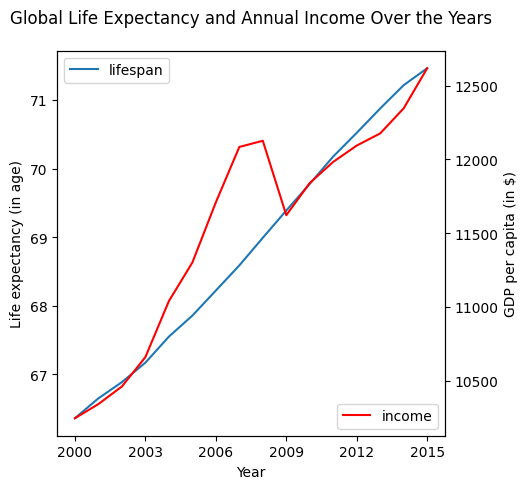

In [47]:
# the global evolution of life expectancy and GDP per capita over the years
df_year = df.groupby('year')

# initialize the figure
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

# plot the lines
ax1.plot(df_year['lifespan'].mean(), label='lifespan')
ax2.plot(df_year['income'].mean(), color='red', label='income')

# adjust the plot
ax1.set_xticks([i for i in range(2000, 2016, 3)])
ax1.set_xlabel('Year')
ax1.set_ylabel('Life expectancy (in age)')
ax1.legend(loc='upper left')
ax2.set_ylabel('GDP per capita (in $)')
ax2.legend(loc='lower right')
plt.title('Global Life Expectancy and Annual Income Over the Years', y=1.05)
plt.show()


- We see that for life expectancy is increasing over the years, it follows a straight line, starting from around 62 years at 2000 to reach 72 years at 2015.  
- Concering GDP per capita, meaning the average annual income of a person in a country, we see that it is also increasing over the years, notice the drop in 2008, this is due to the financial crisis.

Keeping up with the global view, let's try to see the distribution of life expectancy and Annual income across the regions.

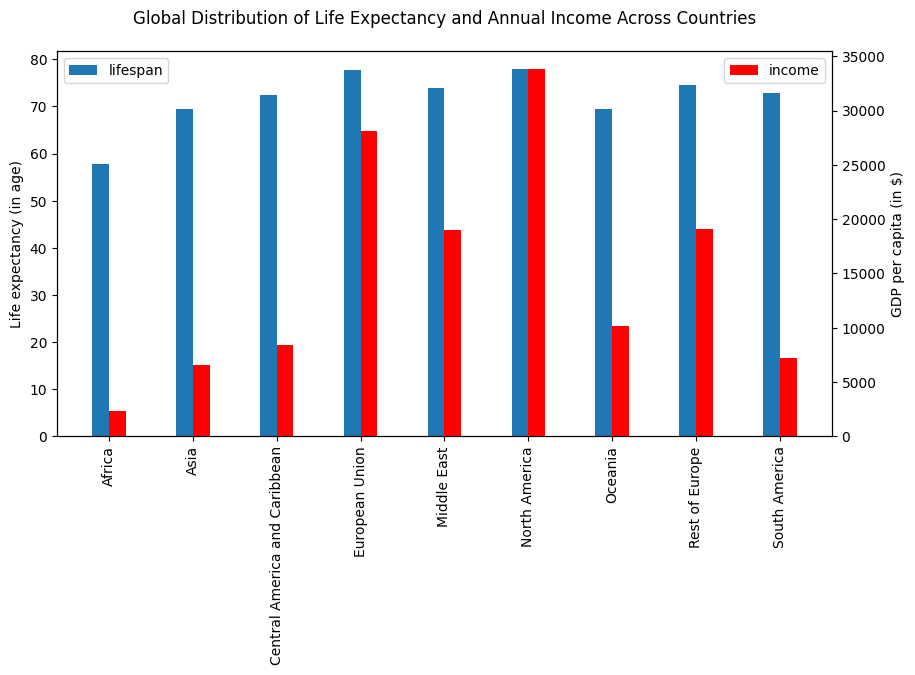

In [48]:
# the global evolution of life expectancy and GDP per capita across countries
df_region = df.groupby('region')

# initialize the figure
fig, ax1 = plt.subplots(figsize=(10, 5))
ax2 = ax1.twinx()

# set the positions of the bars on the x-axis
lifespan_positions = [i for i in range(9)]
income_positions = [i+0.2 for i in lifespan_positions]


# plot the bars
ax1.bar(lifespan_positions, df_region['lifespan'].mean(), width=0.2, label='lifespan')
ax2.bar(income_positions, df_region['income'].mean(), width=0.2, color='red', label='income')

# adjust the plot
ax1.set_xticks([i+0.1 for i in range(9)])
ax1.set_xticklabels(df_region['income'].mean().index, rotation=90)
ax1.set_ylabel('Life expectancy (in age)')
ax1.legend(loc='upper left')
ax2.set_ylabel('GDP per capita (in $)')
ax2.legend(loc='upper right')
plt.title('Global Distribution of Life Expectancy and Annual Income Across Countries', y=1.05)
plt.show()

- The lifespan is the lowest in Africa with an average of 59 years, and the highest in both NA and EU with an average of 77, that's almost a different of 20 years, for other regions, the lifespan is between 69 and 74 years.
- The average annual income is also the lowest in Africa, and the highest in NA, with a difference of 33,000 dollars, we also see that the trend for the annual income and lifespan is the same, the higher the income on a country, the higher the lifespan of its people.

Given this disparity between the regions, and the evolution over the years we saw in the previous graph, we can say that the region, the year and the GDP per capita are associated with the life expectancy, the relationship is not causal, because we cannot say for example that moving from one year to another will cause an increase or decrease in the lifespan, but there is a correlation between these variables.

Now, let's analyze the health indicators, we will start with the mortality rate of the different ages (adults, children, infants), refering to the number of deaths per 1000 live births.

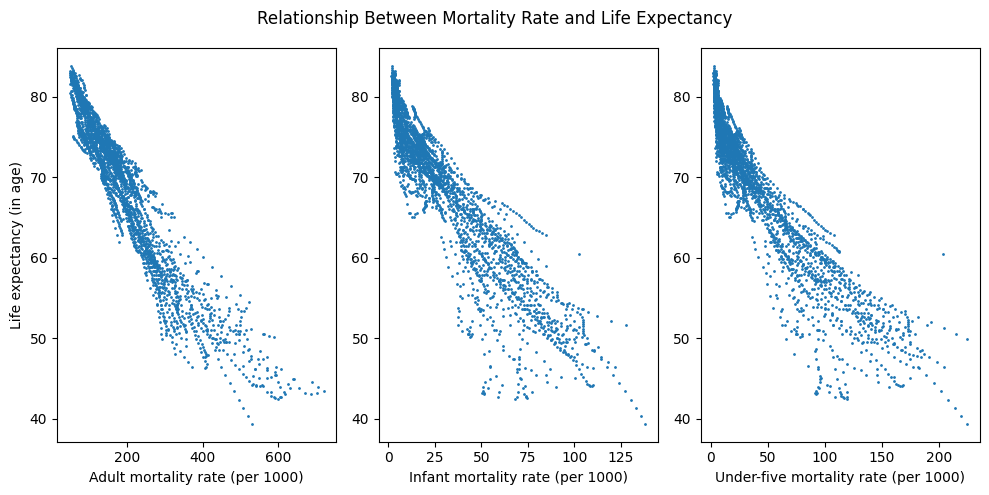

In [64]:
# relationship between mortality rate and life expectancy
fig, ax = plt.subplots(1, 3, figsize=(10, 5))

# plot the scatters
ax[0].scatter(df['adult_deaths'], df['lifespan'], s=1)
ax[1].scatter(df['infant_deaths'], df['lifespan'], s=1)
ax[2].scatter(df['under_five_deaths'], df['lifespan'], s=1)

# adjust the plots
ax[0].set_xlabel('Adult mortality rate (per 1000)')
ax[0].set_ylabel('Life expectancy (in age)')
ax[1].set_xlabel('Infant mortality rate (per 1000)')
ax[2].set_xlabel('Under-five mortality rate (per 1000)')
plt.suptitle('Relationship Between Mortality Rate and Life Expectancy')
plt.tight_layout()
plt.show()

- There is a strong relationship between mortality rate and lifespan, this relationship is negative, meaning that the higher the mortality rate, the lower the lifespan, and vice versa. This is logical, because the higher the mortality rate, the more people die, and the less people are alive, so the average lifespan will be lower.
- We also see a high density of points in lower values of mortality rate.

In [12]:
df.head()

,country,region,year,infant_deaths,under_five_deaths,adult_deaths,alcohol,hepatitis_b,measles,bmi,polio,diphtheria,incidents_hiv,gdp_per_capita,population_mln,thinness_ten_nineteen_years,thinness_five_nine_years,schooling,life_expectancy,status
0,Turkiye,Middle East,2015,11.1,13.0,105.8240,1.32,97,65,27.8,97,97,0.08,11006,78.53,4.9,4.8,7.8,76.5,developing
1,Spain,European Union,2015,2.7,3.3,57.9025,10.35,97,94,26.0,97,97,0.09,25742,46.44,0.6,0.5,9.7,82.8,developed
2,India,Asia,2007,51.5,67.9,201.0765,1.57,60,35,21.2,67,64,0.13,1076,1183.21,27.1,28.0,5.0,65.4,developing
3,Guyana,South America,2006,32.8,40.5,222.1965,5.68,93,74,25.3,92,93,0.79,4146,0.75,5.7,5.5,7.9,67.0,developing
4,Israel,Middle East,2012,3.4,4.3,57.9510,2.89,97,89,27.0,94,94,0.08,33995,7.91,1.2,1.1,12.8,81.7,developed
